In [0]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

In [0]:
def get_6_points_on_ellipse(center, axes, angle):
  pts = cv.ellipse2Poly(center,axes,angle, 0, 360, 60)
  return pts[:6]

In [0]:
def find_ellipse_by6points(points):
  if len(points) < 6:
    raise Exception("There is no enough points")
    
  m = np.zeros((6,6))
  r = np.zeros((6,1))

  for k in range(0, len(points)):
    m[k][0] = points[k][0]*points[k][0]
    m[k][1] = 2*points[k][0]*points[k][1]
    m[k][2] = points[k][1]*points[k][1]
    m[k][3] = 2*points[k][0]
    m[k][4] = 2*points[k][1]
    m[k][5] = 1

  
  mu, ms, mv = np.linalg.svd(m)
  R = mv[-1,:]
  R /= R[0]


  E = np.array(
      [[R[0], R[1], R[3]],
      [R[1], R[2], R[4]],
      [R[3], R[4], R[5]] ], np.double )
  
  if E[0,0]*E[1,1] <= E[0,1]*E[1,0]:
    return None
  
  u, s, v = np.linalg.svd(E)
  u2 = np.matmul(u, np.diag(np.sqrt(s)) )
  H = np.linalg.inv( u2.T)
  
  
  ellipse_points = []
  for alpha in range(0,361):
    a = np.matmul( H, [[np.sin(np.pi*alpha/180)], [np.cos(np.pi*alpha/180)], [1]] )
    a = (a/a[2])
    
    ellipse_points.append((int(a[0][0]), int(a[1][0])))
    
  
  return ellipse_points

In [0]:
def nose_points(points, sigma):
  size = len(points)
  r = np.random.normal(0, sigma, size)
  phi = np.random.uniform(0, np.pi, size)
  
  noise_points = points.copy()
  for i in range(0, size):
    r = np.random.normal(0, sigma, 1)[0]
    phi = np.random.uniform(0, np.pi, 1)[0]
    noise_points[i][0] += r*np.cos(phi)
    noise_points[i][1] += r*np.sin(phi)
    
  return noise_points
  

In [0]:
def find_min_square_distance_from_point_to_ellipse(point, center, axes, angle):
  ellipse_points = cv.ellipse2Poly(center, axes, angle, 0, 360, 1)
  
  min_dist2 = 2147483647
  min_index = -1
  for i in range(0, len(ellipse_points)):
    d2 = (ellipse_points[i][0] - point[0])**2 + (ellipse_points[i][1] - point[1])**2
    
    if min_dist2 > d2:
      min_dist2 = d2
      min_index = i
    
  
  return min_dist2
    
    

In [0]:
def find_fatherst_point_from_ellipse(points, center, axes, angle):
  max_dist2 = 0
  fatherst_point = None
  
  for point in points:
    min_dist2 = find_min_square_distance_from_point_to_ellipse(point, center, axes, angle)
    
    if max_dist2 < min_dist2:
      max_dist2 = min_dist2
      fatherst_point = point
            
  return fatherst_point, np.sqrt(max_dist2)
    
  

Initial ellipse parameters

In [0]:
center = (256, 256)
axes = (200, 100)
angle = 45

In [8]:
points6 = get_6_points_on_ellipse(center, axes, angle)
points6

array([[397, 397],
       [265, 388],
       [124, 247],
       [115, 115],
       [247, 124],
       [388, 265]], dtype=int32)

Initial ellipse and selected points


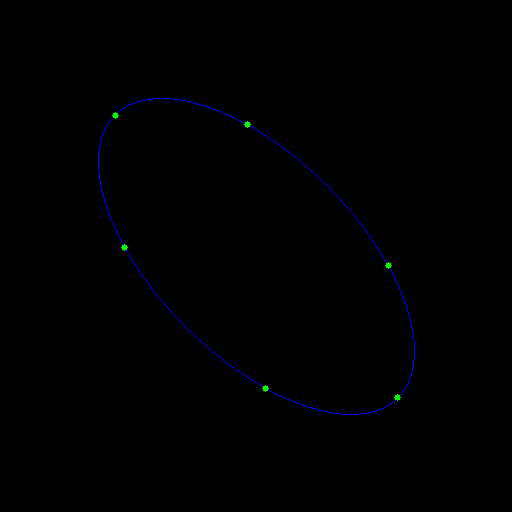

In [9]:
img = np.zeros((512,512,3), np.uint8)
cv.ellipse(img, center, axes, angle, 0, 360, (255, 0, 0), 1)
for point in points6:
  cv.circle(img, (point[0], point[1]), 3,(0,255,0), -1)
print("Initial ellipse and selected points")
cv2_imshow(img)

In [0]:
sigma = 40

Initial ellipse and noise points with sigma=40


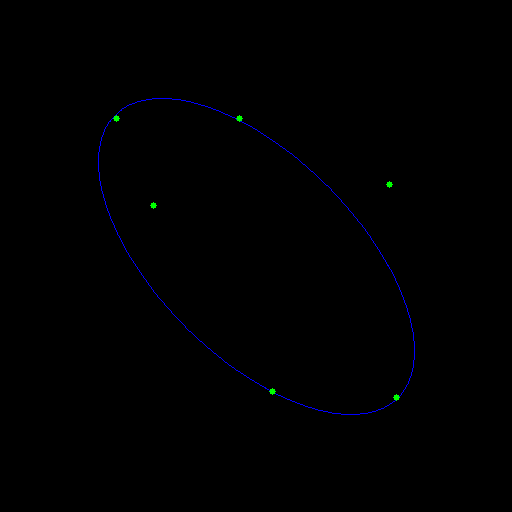

In [11]:
noise_points6 = nose_points(points6, sigma)
img = np.zeros((512,512,3), np.uint8)
cv.ellipse(img, center, axes, angle, 0, 360, (255, 0, 0), 1)
for point in noise_points6:
  cv.circle(img, (point[0], point[1]), 3,(0,255,0), -1)
print(f"Initial ellipse and noise points with sigma={sigma}")
cv2_imshow(img)

Find ellispe by these noise points


In [0]:
ellipse_points = find_ellipse_by6points(noise_points6)
if ellipse_points is None:
  print("Ellipse was not found")

Found ellispe. Sigma=40


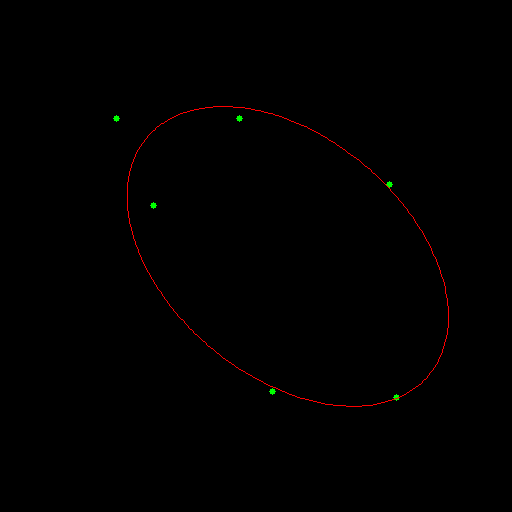

In [13]:
img = np.zeros((512,512,3), np.uint8)

for point in noise_points6:
  cv.circle(img, (point[0], point[1]), 3,(0,255,0), -1)
  
for k in range(0, len(ellipse_points)-1):
  cv.line(img, ellipse_points[k], ellipse_points[k+1], (0, 0, 255))


print(f"Found ellispe. Sigma={sigma}")
cv2_imshow(img)

Run the experiments


In [14]:
points6

array([[397, 397],
       [265, 388],
       [124, 247],
       [115, 115],
       [247, 124],
       [388, 265]], dtype=int32)

In [0]:
num_of_experiments = 10
sigmas = np.array(range(1, 40, 1))

In [35]:
max_distances = np.zeros(len(sigmas))
for i in range(0, len(sigmas)):
  sum_dist = 0
  num = 0
  for n in range(num_of_experiments):
    noise_points6 = nose_points(points6, sigmas[i])
    found_ellipse_points = find_ellipse_by6points(noise_points6)
    if found_ellipse_points is None:
      print("No ellipse found")
      continue
      
    p, dist = find_fatherst_point_from_ellipse(found_ellipse_points, center, axes, angle)
    
    if dist > 1000:
      print("noise points", noise_points6)
      print("flound ellipse", found_ellipse_points)
    
    sum_dist += dist
    num +=1 
    
  max_distances[i] = sum_dist / num
               
max_distances

noise points [[391 417]
 [268 363]
 [125 226]
 [ 10 109]
 [237 117]
 [374 260]]
flound ellipse [(-2587, -2028), (-2847, -2233), (-3167, -2484), (-3568, -2799), (-4087, -3207), (-4784, -3756), (-5770, -4532), (-7269, -5712), (-9823, -7724), (-15153, -11924), (-33153, -26109), (176003, 138734), (24075, 18995), (12920, 10205), (8830, 6982), (6707, 5310), (5407, 4286), (4530, 3596), (3898, 3099), (3421, 2724), (3049, 2432), (2750, 2197), (2505, 2005), (2300, 1844), (2127, 1709), (1978, 1592), (1849, 1491), (1736, 1403), (1636, 1326), (1548, 1257), (1469, 1195), (1397, 1140), (1333, 1090), (1274, 1045), (1221, 1004), (1172, 967), (1127, 932), (1086, 900), (1047, 871), (1012, 844), (979, 819), (948, 796), (920, 775), (893, 755), (868, 736), (844, 718), (822, 702), (801, 686), (781, 672), (763, 658), (745, 646), (729, 633), (713, 622), (698, 611), (684, 601), (670, 592), (658, 583), (645, 574), (634, 566), (623, 559), (612, 552), (602, 545), (593, 538), (583, 532), (575, 527), (566, 521), (55

array([3.22146223e+00, 3.15932498e+00, 3.93250842e+00, 5.39051034e+00,
       7.19697535e+00, 8.19274408e+00, 8.91554622e+00, 8.95948255e+00,
       1.22026100e+01, 1.29822605e+01, 1.27886530e+01, 1.59482296e+01,
       1.44463568e+01, 1.77132202e+01, 1.91287917e+01, 1.90563977e+01,
       2.33683105e+01, 2.20954236e+01, 2.48523374e+01, 2.37841821e+01,
       2.59841821e+01, 2.94662920e+01, 2.99701050e+01, 2.99328130e+01,
       5.10646120e+01, 4.44582739e+01, 3.25702709e+01, 3.87535304e+01,
       3.87379282e+01, 3.55851585e+01, 4.42322983e+01, 3.87408088e+01,
       5.21365041e+01, 3.39748506e+01, 5.28216298e+01, 5.23326540e+03,
       7.25664948e+01, 5.40837621e+01, 4.09111096e+01])

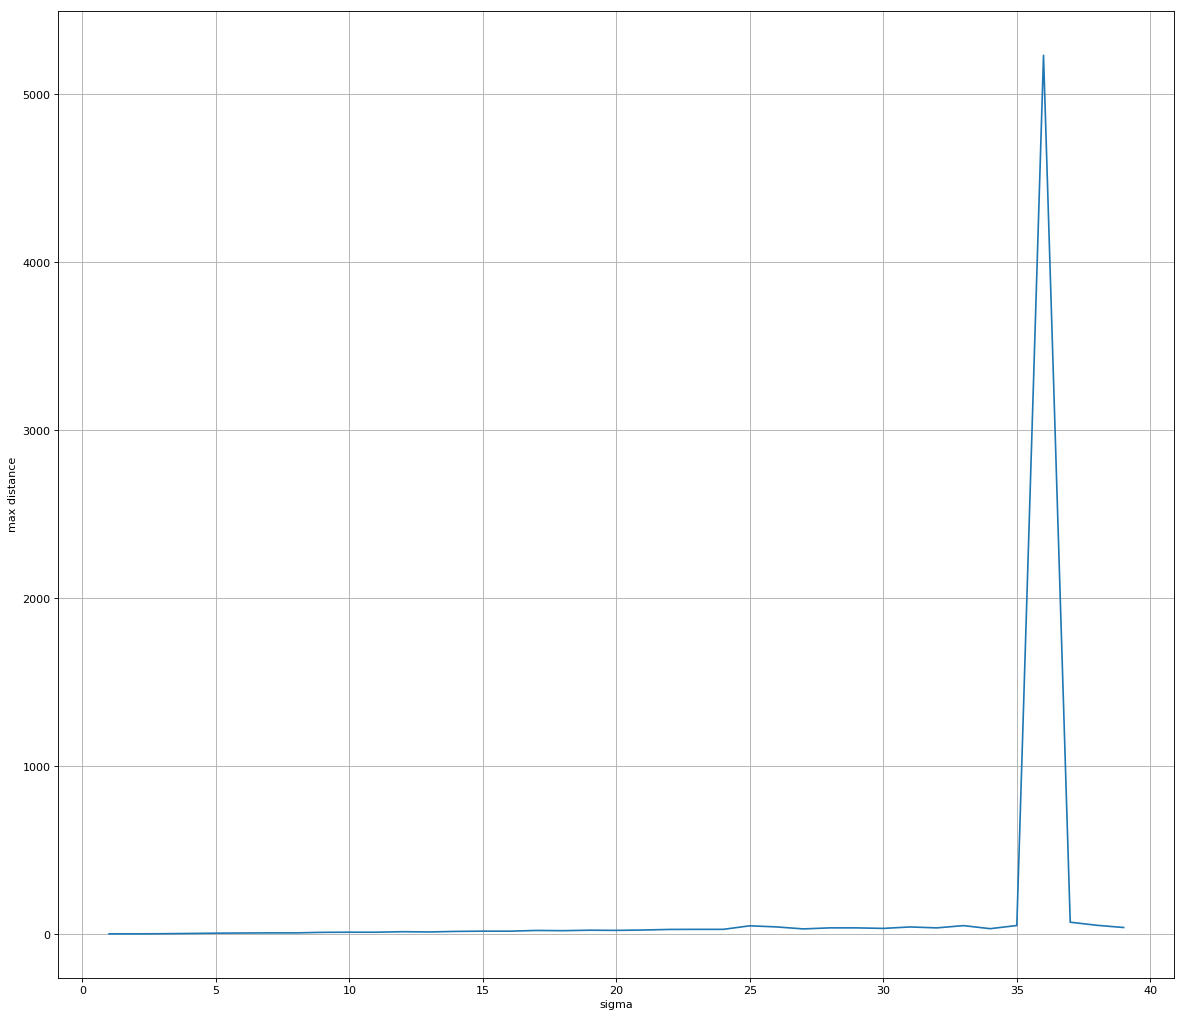

In [36]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sigmas, max_distances)
plt.ylabel('max distance')
plt.xlabel('sigma')
plt.grid()
plt.show()


In the graph above, we can notice that maximum distance increasse with sigma. Futhemore, we noticed one intersting behavior when we have huge distance, it can caused by big scatter of noise points in some occasionaly case. 